In [1]:
import sys
sys.path.append('..')  # Add parent directory to path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

from src.data_processing.load_data import BCIDataLoader

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports successful!")


✓ Imports successful!


In [2]:
print("Loading Subject 1 data...")
loader = BCIDataLoader(subject_ids=[1])
data = loader.load_all_subjects()

X = data[1]['X']  # Shape: (576, 22, 751)
y = data[1]['y']  # Shape: (576,)
info = data[1]['info']

print(f"\n✓ Data loaded!")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

BNCI2014001 has been renamed to BNCI2014_001. BNCI2014001 will be removed in version 1.1.
The dataset class name 'BNCI2014001' must be an abbreviation of its code 'BNCI2014-001'. See moabb.datasets.base.is_abbrev for more information.


Loading Subject 1 data...
LOADING 1 SUBJECT(S)
Loading Subject 1...
  ✓ Shape: (576, 22, 751)
  ✓ Classes: (array([0, 1, 2, 3]), array([144, 144, 144, 144]))

✓ 1 SUBJECT(S) LOADED SUCCESSFULLY

✓ Data loaded!
X shape: (576, 22, 751)
y shape: (576,)


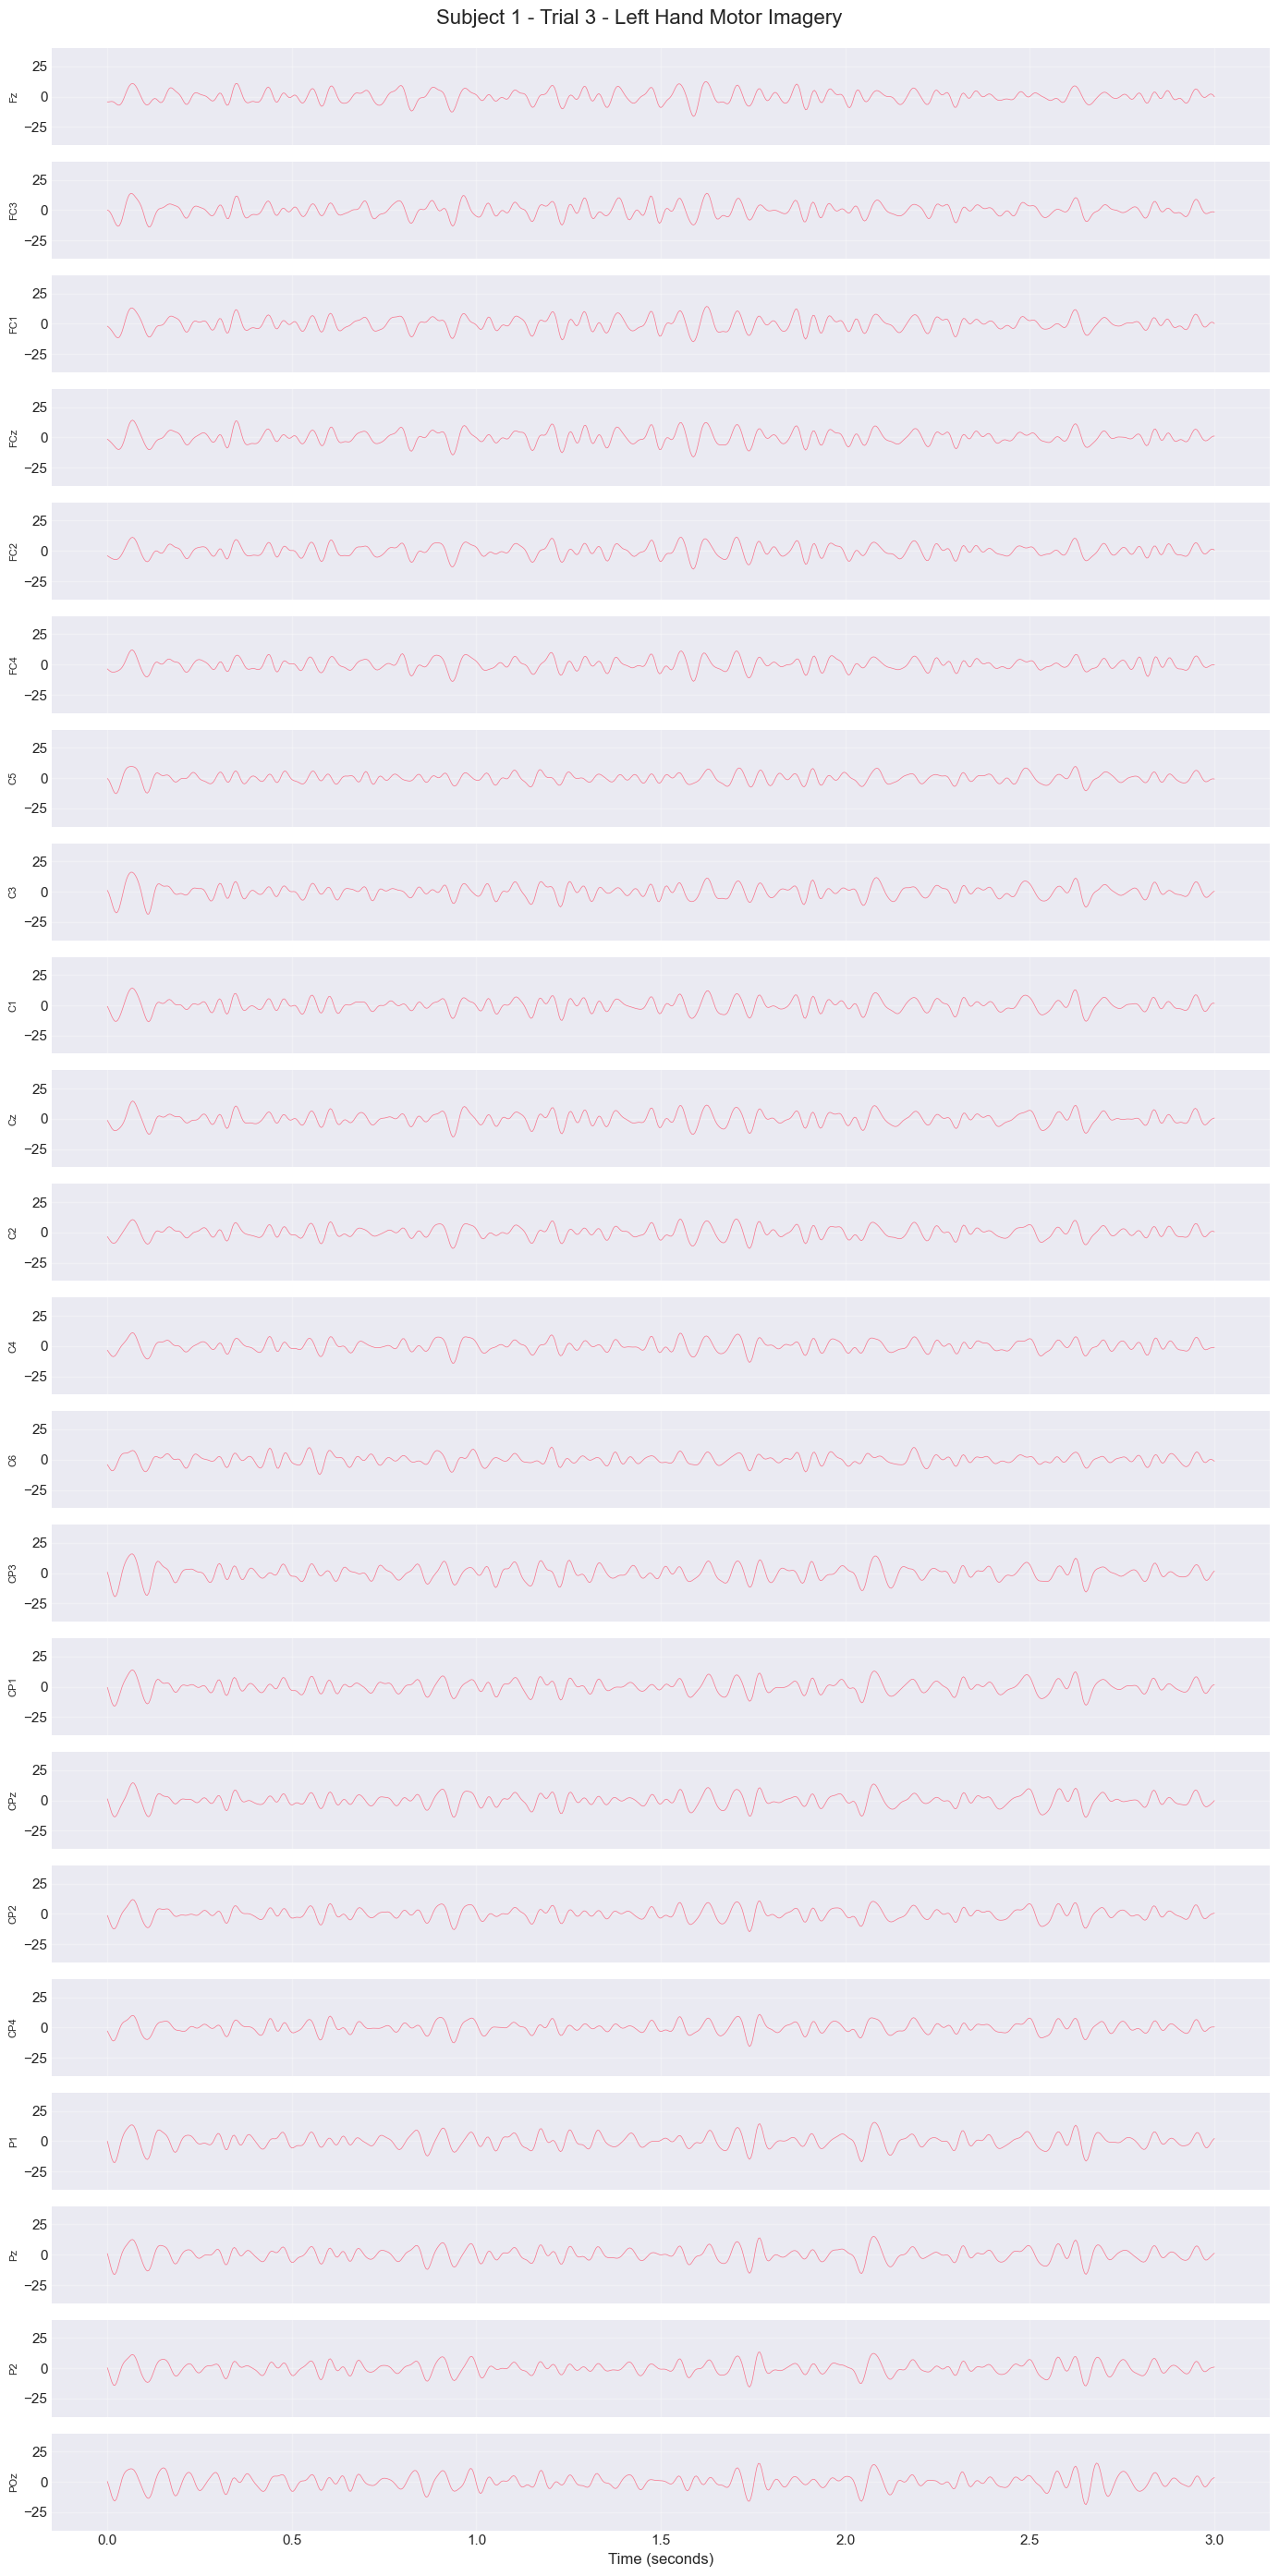

This is raw EEG from 22 electrodes while imagining moving left hand!


In [3]:
# Find first left_hand trial
left_hand_idx = np.where(y == 0)[0][0]

# Time axis
time = np.arange(X.shape[2]) / info['sfreq']  # Convert to seconds

# Plot all 22 channels
fig, axes = plt.subplots(22, 1, figsize=(14, 28), sharex=True)
fig.suptitle(f'Subject 1 - Trial {left_hand_idx} - Left Hand Motor Imagery', 
             fontsize=16, y=0.995)

for ch in range(22):
    axes[ch].plot(time, X[left_hand_idx, ch, :], linewidth=0.5)
    axes[ch].set_ylabel(info['channel_names'][ch], fontsize=8)
    axes[ch].grid(True, alpha=0.3)
    axes[ch].set_ylim(-40, 40)
    
axes[-1].set_xlabel('Time (seconds)')
plt.tight_layout()
plt.show()

print("This is raw EEG from 22 electrodes while imagining moving left hand!")

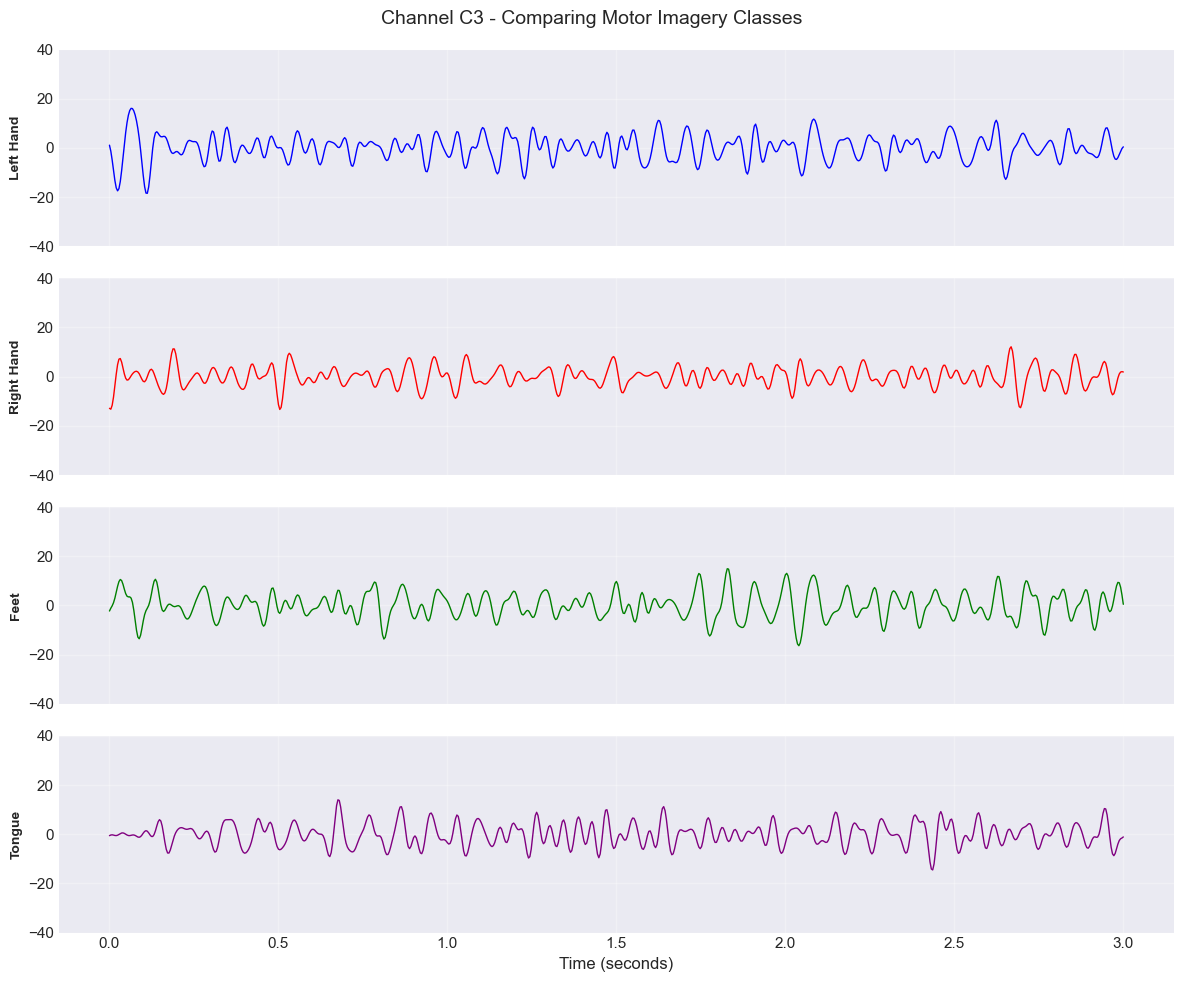

Notice: Different movement types have subtle differences!


In [4]:
# Get one trial of each class
trial_indices = []
for cls in range(4):
    idx = np.where(y == cls)[0][0]  # First trial of this class
    trial_indices.append(idx)

class_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']
colors = ['blue', 'red', 'green', 'purple']

# Plot one important channel (C3 - left motor cortex)
channel_idx = 7  # C3 channel

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
fig.suptitle(f'Channel C3 - Comparing Motor Imagery Classes', fontsize=14)

for i, (idx, name, color) in enumerate(zip(trial_indices, class_names, colors)):
    axes[i].plot(time, X[idx, channel_idx, :], color=color, linewidth=1)
    axes[i].set_ylabel(name, fontsize=10, fontweight='bold')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(-40, 40)

axes[-1].set_xlabel('Time (seconds)')
plt.tight_layout()
plt.show()

print("Notice: Different movement types have subtle differences!")

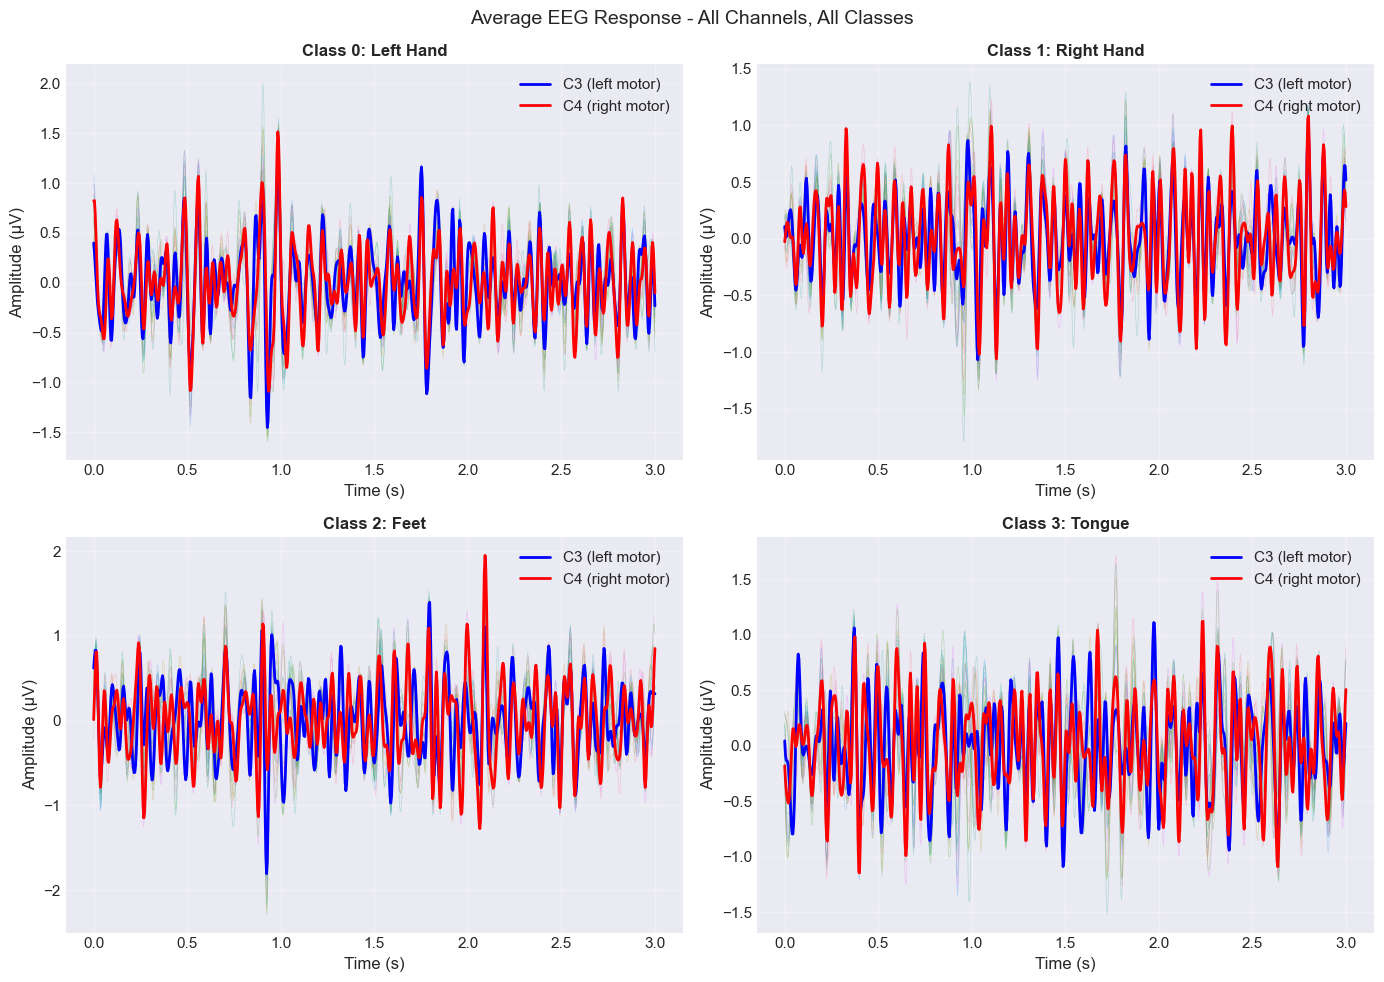

Averaged across 144 trials per class - patterns emerge!


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Average EEG Response - All Channels, All Classes', fontsize=14)

for cls in range(4):
    ax = axes[cls // 2, cls % 2]
    
    # Get all trials of this class
    class_trials = X[y == cls]  # Shape: (144, 22, 751)
    
    # Average across trials
    avg_trials = class_trials.mean(axis=0)  # Shape: (22, 751)
    
    # Plot all channels
    for ch in range(22):
        ax.plot(time, avg_trials[ch, :], alpha=0.3, linewidth=0.5)
    
    # Highlight C3 and C4 (motor cortex)
    ax.plot(time, avg_trials[7, :], color='blue', linewidth=2, label='C3 (left motor)')
    ax.plot(time, avg_trials[11, :], color='red', linewidth=2, label='C4 (right motor)')
    
    ax.set_title(f'Class {cls}: {class_names[cls]}', fontweight='bold')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude (µV)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("Averaged across 144 trials per class - patterns emerge!")


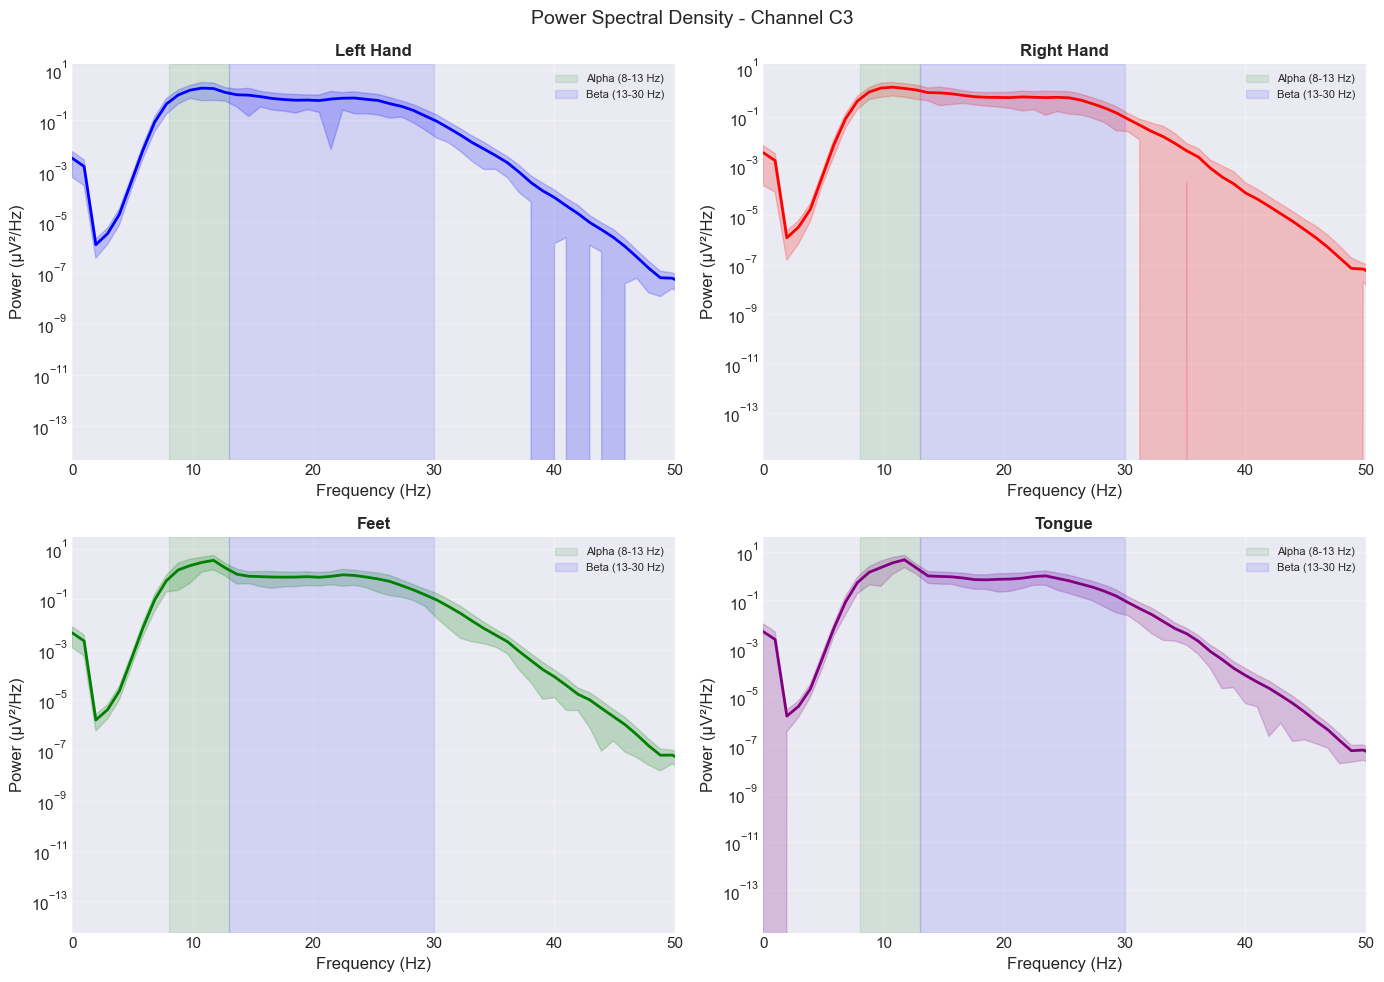

Motor imagery shows up in 8-30 Hz (alpha & beta bands)!


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Power Spectral Density - Channel C3', fontsize=14)

for cls in range(4):
    ax = axes[cls // 2, cls % 2]
    
    # Get all trials of this class
    class_trials = X[y == cls, channel_idx, :]  # C3 channel
    
    # Compute PSD for each trial
    all_psds = []
    for trial in class_trials:
        freqs, psd = signal.welch(trial, fs=info['sfreq'], nperseg=256)
        all_psds.append(psd)
    
    # Average PSD
    avg_psd = np.array(all_psds).mean(axis=0)
    std_psd = np.array(all_psds).std(axis=0)
    
    # Plot
    ax.semilogy(freqs, avg_psd, color=colors[cls], linewidth=2)
    ax.fill_between(freqs, avg_psd - std_psd, avg_psd + std_psd, 
                     color=colors[cls], alpha=0.2)
    
    # Highlight motor imagery bands
    ax.axvspan(8, 13, alpha=0.1, color='green', label='Alpha (8-13 Hz)')
    ax.axvspan(13, 30, alpha=0.1, color='blue', label='Beta (13-30 Hz)')
    
    ax.set_title(f'{class_names[cls]}', fontweight='bold')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power (µV²/Hz)')
    ax.set_xlim(0, 50)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

print("Motor imagery shows up in 8-30 Hz (alpha & beta bands)!")

In [7]:
print("=" * 60)
print("SUBJECT 1 DATA SUMMARY")
print("=" * 60)

print(f"\nTotal trials: {X.shape[0]}")
print(f"Channels: {X.shape[1]}")
print(f"Timepoints per trial: {X.shape[2]}")
print(f"Sampling rate: {info['sfreq']} Hz")
print(f"Trial duration: {info['duration']:.2f} seconds")

print("\nClass distribution:")
for cls in range(4):
    count = (y == cls).sum()
    print(f"  {class_names[cls]:12s}: {count} trials")

print("\nSignal statistics:")
print(f"  Mean: {X.mean():.4f} µV")
print(f"  Std: {X.std():.4f} µV")
print(f"  Min: {X.min():.2f} µV")
print(f"  Max: {X.max():.2f} µV")

print("\n" + "=" * 60)
print("✓ EXPLORATION COMPLETE!")
print("=" * 60)
print("\nKey Takeaways:")
print("1. EEG signals are noisy but contain patterns")
print("2. Different movements show subtle differences")
print("3. Motor imagery appears in 8-30 Hz frequencies")
print("4. Data is clean, balanced, and ready for processing")
print("\n✓ Ready for Day 3: Preprocessing Pipeline!")

SUBJECT 1 DATA SUMMARY

Total trials: 576
Channels: 22
Timepoints per trial: 751
Sampling rate: 250 Hz
Trial duration: 3.00 seconds

Class distribution:
  Left Hand   : 144 trials
  Right Hand  : 144 trials
  Feet        : 144 trials
  Tongue      : 144 trials

Signal statistics:
  Mean: 0.0003 µV
  Std: 4.9161 µV
  Min: -42.30 µV
  Max: 40.47 µV

✓ EXPLORATION COMPLETE!

Key Takeaways:
1. EEG signals are noisy but contain patterns
2. Different movements show subtle differences
3. Motor imagery appears in 8-30 Hz frequencies
4. Data is clean, balanced, and ready for processing

✓ Ready for Day 3: Preprocessing Pipeline!
